# Aviation Risk Analysis: A Data-Driven Lens for Smarter Investment

### Objective

The aviation industry is capital-intensive and high-risk. For investors and new entrants, knowing where the real threats lie across aircraft types, engine classes, and flight phases isn’t just a regulatory checkbox. It’s a competitive edge.

This project analyzes over **90,000 historical aviation incidents** to surface high-risk clusters, isolate operational weak points, and identify **low-volatility entry points** for strategic investment.


### Why It Matters

Aviation accidents are rare, but when they occur, the losses are severe financially, reputationally, and operationally. Most early-stage investors enter the market blind to the granular risk profiles hidden in public incident data.

This notebook brings those risks to the surface highlighting the **aircraft makes, engine types, and flight phases** most frequently involved in incidents, injuries, and fatalities.


### End Goal

Equip investors and operators with a **risk-aligned decision framework** for:
- Assessing fleet composition and engine selection
- Screening operational partners by data completeness and flight transparency
- Avoiding high-risk clusters and favoring controlled environments

By the end of this analysis, we aim to deliver **3 sharp recommendations** for navigating entry into aviation with lower exposure and higher control.


In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('../data/Aviation_Data.csv', low_memory=False)

# Preview first few rows
df.head()


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [2]:
df.shape


(90348, 31)

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

In [4]:
df.isnull().sum().sort_values(ascending=False).head(20)


Schedule                  77766
Air.carrier               73700
FAR.Description           58325
Aircraft.Category         58061
Longitude                 55975
Latitude                  55966
Airport.Code              40216
Airport.Name              37644
Broad.phase.of.flight     28624
Publication.Date          16689
Total.Serious.Injuries    13969
Total.Minor.Injuries      13392
Total.Fatal.Injuries      12860
Engine.Type                8555
Report.Status              7843
Purpose.of.flight          7651
Number.of.Engines          7543
Total.Uninjured            7371
Weather.Condition          5951
Aircraft.damage            4653
dtype: int64

## Selecting Relevant Columns

To focus the analysis on risk patterns, we keep only the features that help us answer:

- When and where events occurred
- The context of flight (phase, purpose)
- Aircraft characteristics linked to risk
- Severity of the outcome (injuries, damage)
- Environmental or operational conditions
- Investigation completeness

Columns like `Registration.Number`, `Airport.Code`, or `Publication.Date` are dropped because they add noise without contributing directly to the risk analysis.


In [5]:
# Select only the most relevant columns for our aviation risk analysis
cols_to_keep = [
    'Event.Date', 'Location', 'Country',
    'Make', 'Model', 'Number.of.Engines', 'Engine.Type', 'Aircraft.damage',
    'Injury.Severity', 'Total.Fatal.Injuries', 'Total.Serious.Injuries',
    'Total.Minor.Injuries', 'Total.Uninjured',
    'Purpose.of.flight', 'Broad.phase.of.flight', 'Weather.Condition',
    'Investigation.Type', 'Report.Status', 'Airport.Name'
]

# Trim the dataset to include only those columns
df_trimmed = df[cols_to_keep].copy()

# Confirm shape after trimming
print("Trimmed shape:", df_trimmed.shape)


Trimmed shape: (90348, 19)


In [6]:
# Check for missing values in the trimmed dataset
missing_data = df_trimmed.isnull().sum().sort_values(ascending=False)

# Display only columns with missing data
missing_data = missing_data[missing_data > 0]

# Show the count and percentage of missing data for each relevant column
missing_percentage = (missing_data / len(df_trimmed)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing %': missing_percentage.round(2)
})

missing_summary


,Missing Count,Missing %
Airport.Name,37644,41.67
Broad.phase.of.flight,28624,31.68
Total.Serious.Injuries,13969,15.46
Total.Minor.Injuries,13392,14.82
Total.Fatal.Injuries,12860,14.23
Engine.Type,8555,9.47
Report.Status,7843,8.68
Purpose.of.flight,7651,8.47
Number.of.Engines,7543,8.35
Total.Uninjured,7371,8.16


In [7]:
# Fill missing values for categorical columns with "Unknown"
categorical_cols = [
    'Make', 'Model', 'Injury.Severity', 'Aircraft.damage',
    'Engine.Type', 'Purpose.of.flight', 'Weather.Condition',
    'Report.Status', 'Broad.phase.of.flight'
]
df_trimmed[categorical_cols] = df_trimmed[categorical_cols].fillna('Unknown')

# Fill missing numeric injury columns with 0 (assumes missing = not reported = 0)
injury_cols = [
    'Total.Fatal.Injuries', 'Total.Serious.Injuries',
    'Total.Minor.Injuries', 'Total.Uninjured'
]
df_trimmed[injury_cols] = df_trimmed[injury_cols].fillna(0)

# Fill missing Number.of.Engines with 1 as a default assumption (many GA aircraft)
df_trimmed['Number.of.Engines'] = df_trimmed['Number.of.Engines'].fillna(1)

# For Airport.Name and Event.Date — fill with "Unknown" or drop if not useful
df_trimmed['Airport.Name'] = df_trimmed['Airport.Name'].fillna('Unknown')
df_trimmed['Event.Date'] = df_trimmed['Event.Date'].fillna('Unknown')
df_trimmed['Location'] = df_trimmed['Location'].fillna('Unknown')
df_trimmed['Country'] = df_trimmed['Country'].fillna('Unknown')


In [8]:
df_trimmed.isnull().sum().sum()

0

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15020\812556383.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_makes.values, y=top_makes.index, palette="Set2")


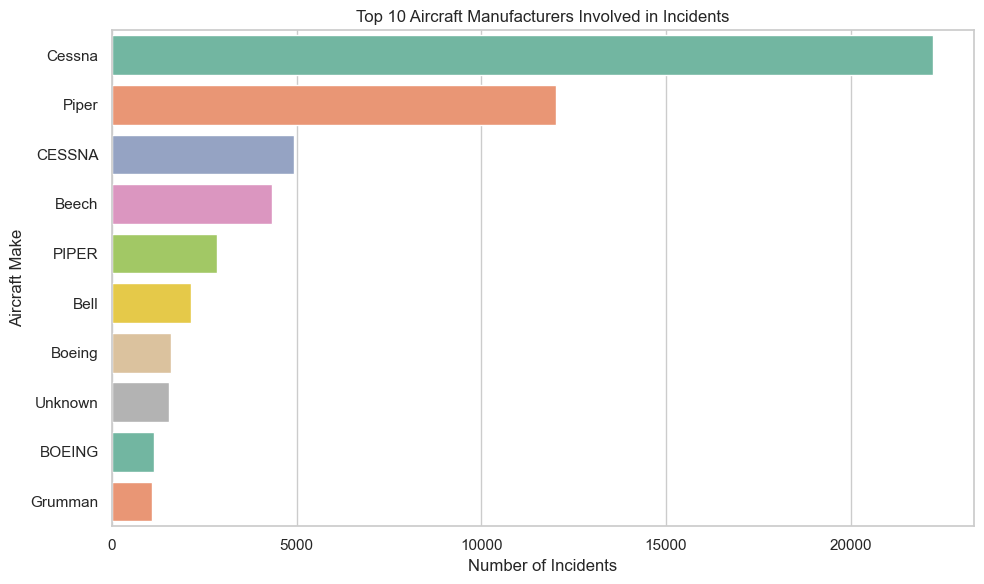

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot top 10 makes
top_makes = df_trimmed['Make'].value_counts().nlargest(10)
sns.barplot(x=top_makes.values, y=top_makes.index, palette="Set2")

plt.title("Top 10 Aircraft Manufacturers Involved in Incidents")
plt.xlabel("Number of Incidents")
plt.ylabel("Aircraft Make")
plt.tight_layout()
plt.show()


### Aircraft Make: Early Insights

Cessna appears as the top and third most frequent make involved in incidents, with Bell and Piper also recurring.

This raises three key possibilities:

- Cessna aircraft may dominate general aviation usage, leading to volume-driven incident counts.
- The presence of multiple Cessna models hints at broader exposure, not just an isolated type issue.
- Many such aircraft may be older, used in low-budget operations, or flown by less-experienced pilots.

Hypothesis: The high presence of Cessna in incident data is likely due to high fleet penetration in general aviation and flight training, possibly amplified by aging aircraft and uneven safety oversight.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15020\3244136380.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


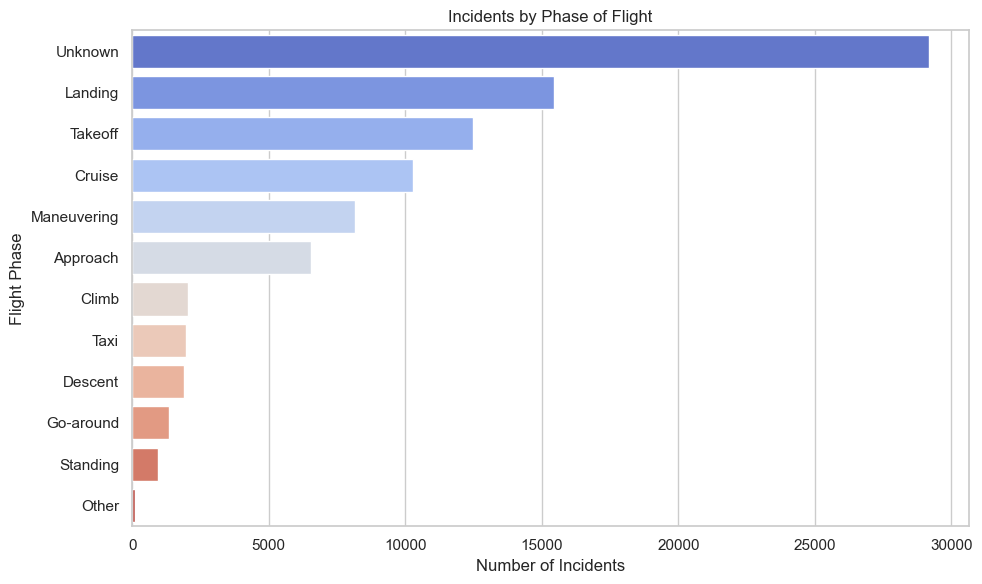

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_trimmed,
    y='Broad.phase.of.flight',
    order=df_trimmed['Broad.phase.of.flight'].value_counts().index,
    palette='coolwarm'
)
plt.title("Incidents by Phase of Flight")
plt.xlabel("Number of Incidents")
plt.ylabel("Flight Phase")
plt.tight_layout()
plt.show()


### Incident Distribution by Phase of Flight

The majority of incidents occur during **Landing** and **Takeoff** phases confirming these as the most operationally sensitive stages. These are high-workload moments with less room for error, especially for less automated or older aircraft.

Notably, **"Unknown"** is the largest category. This signals gaps in investigation quality or data reporting, particularly in smaller or international contexts. For investors, this is a red flag: **lack of visibility equals increased operational uncertainty**.

Better training, aircraft upgrades, or due diligence on jurisdictions with full reporting may help reduce exposure in these critical phases.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15020\2126995665.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


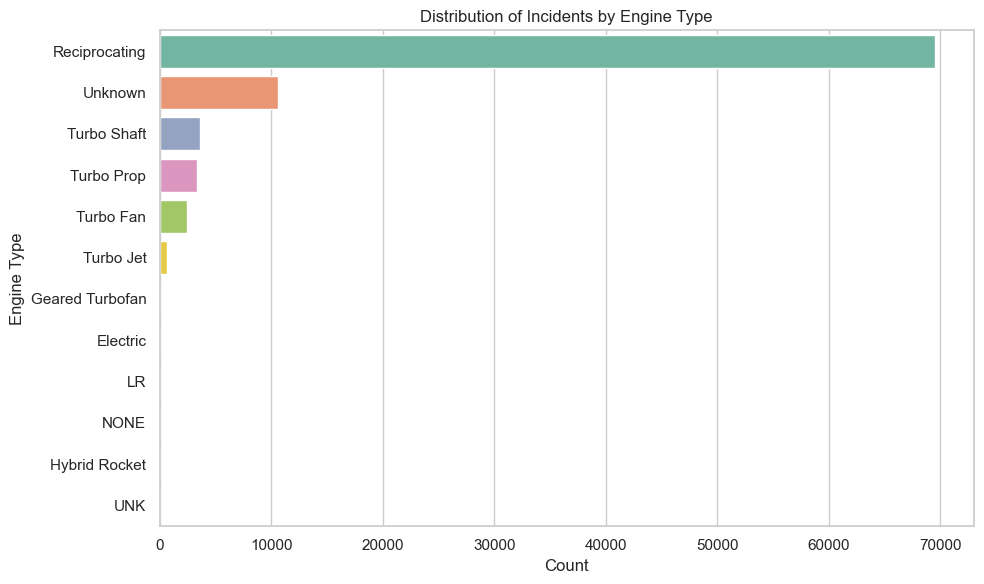

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_trimmed,
    y='Engine.Type',
    order=df_trimmed['Engine.Type'].value_counts().index,
    palette='Set2'
)
plt.title("Distribution of Incidents by Engine Type")
plt.xlabel("Count")
plt.ylabel("Engine Type")
plt.tight_layout()
plt.show()


### Engine Type Distribution – Observations & Implications

The majority of incident reports involve **reciprocating engines**, with nearly 7,000 cases, a stark contrast to all other engine types. This is followed distantly by **turbo shaft, turbo prop**, and other turbine-based engines. The high count for **"Unknown"** suggests either incomplete reporting or engine types less frequently documented.

**Investor Insight:**
Reciprocating engines are common in smaller general aviation aircraft, which are often older, more widely used, and operated in less regulated environments. Their prevalence here may reflect both volume and vulnerability. While turbine engines (e.g., turbo jet, turbo fan) dominate commercial fleets, their lower incident counts could indicate stronger regulatory oversight or better safety margins which are factors that matter when assessing investment in fleet type or target market segment.

## Severity Matters: Fatal Injuries by Aircraft Make

While earlier charts focused on **how frequently** different aircraft makes appear in accident data, frequency alone doesn’t tell the whole story.

An investor also needs to understand **how severe** incidents tend to be especially in terms of **fatal injuries**, which have the most serious regulatory, financial, and reputational consequences.

This chart shifts the lens from "how often" to **"how deadly"**.

We’re asking:
- Which aircraft makes are involved in incidents with the highest **total number of fatalities**?
- Are there specific manufacturers where outcomes tend to be more catastrophic?

This helps highlight makes where operational risk is not only more likely but potentially more devastating.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15020\2707147738.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


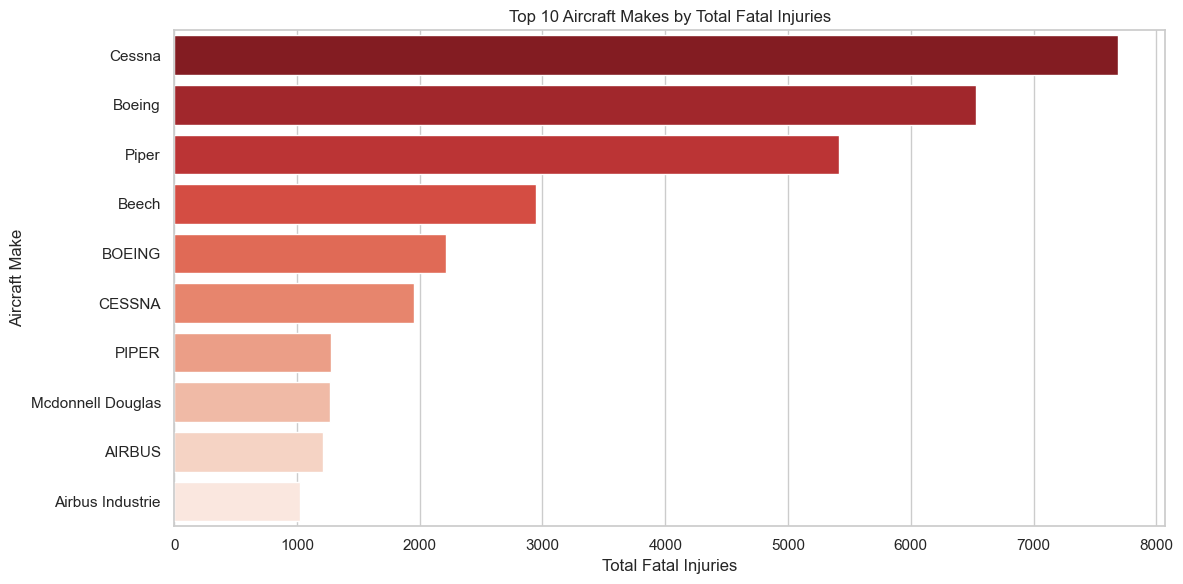

In [12]:
# Group by aircraft make and sum fatal injuries
fatalities_by_make = (
    df_trimmed.groupby('Make')['Total.Fatal.Injuries']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=fatalities_by_make.values,
    y=fatalities_by_make.index,
    palette='Reds_r'
)
plt.title('Top 10 Aircraft Makes by Total Fatal Injuries')
plt.xlabel('Total Fatal Injuries')
plt.ylabel('Aircraft Make')
plt.tight_layout()
plt.show()


### Observing Fatality Impact by Aircraft Make

This plot shifts the lens from frequency to **fatality impact** helping us evaluate not just *how often* incidents occur, but *how severe* they are.

**Key observations:**
- **Cessna** leads by a significant margin, with over 7,000 total fatal injuries likely due to the high volume of general aviation use and potentially aging fleet.
- **Boeing** appears multiple times, reflecting the diversity of aircraft models and possible data inconsistencies in naming.
- **Piper** and **Beech** also show substantial fatality counts, reinforcing the investor need to differentiate between general aviation and commercial trends.

**Why this matters:**
For early-stage investors or risk assessors, it's not just the *presence* of a manufacturer in the dataset, it's the **combination of frequency and fatality severity** that flags attention. 

Makes with high fatality loads may:
- Operate in less regulated or less controlled environments
- Be involved in training or recreational flights
- Represent an aging fleet requiring higher maintenance and oversight

This sets the tone for future due diligence efforts around **fleet condition**, **use context**, and **operational oversight** which are key risk levers in aviation investment.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15020\542465039.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


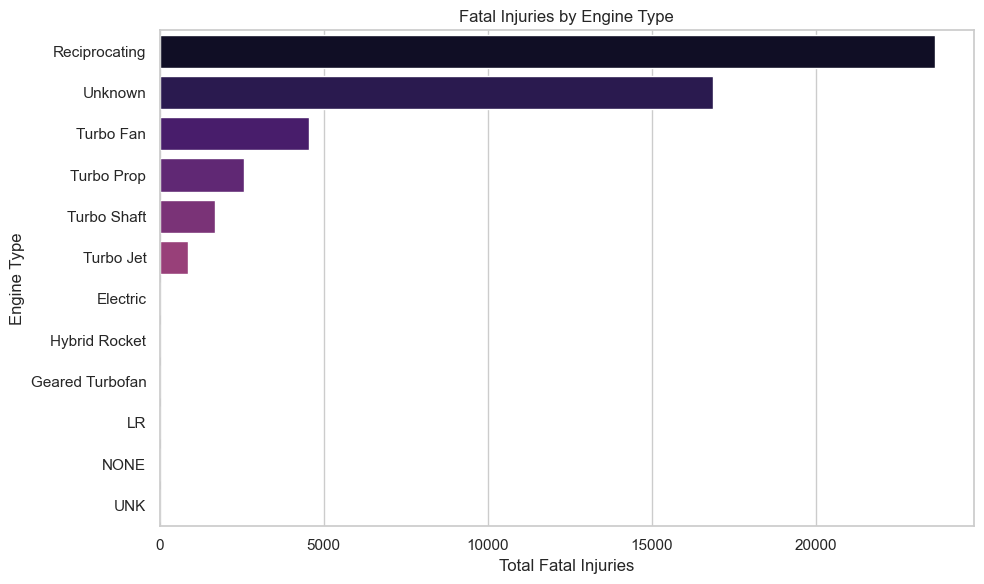

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_trimmed.groupby('Engine.Type')['Total.Fatal.Injuries'].sum().reset_index().sort_values(by='Total.Fatal.Injuries', ascending=False),
    x='Total.Fatal.Injuries', y='Engine.Type', palette='magma'
)
plt.title("Fatal Injuries by Engine Type")
plt.xlabel("Total Fatal Injuries")
plt.ylabel("Engine Type")
plt.tight_layout()
plt.show()


### Engine Type vs. Fatal Injuries

Reciprocating engines account for the highest total number of fatal injuries by a large margin, over 20,000, followed by significantly lower totals for turbine-based engines (turbo fan, turbo prop, turbo shaft).

This could reflect two things:

* **Exposure bias**: Reciprocating engines dominate general aviation fleets, which fly frequently and in diverse conditions.
* **Risk profile**: These engines often power smaller aircraft with lower redundancy, lower altitude cruising, and potentially weaker crash survivability.

For risk-aware investors or insurers, this chart signals a need for:

* Closer scrutiny of general aviation operations using reciprocating engines
* Stronger controls or training protocols for small-engine aircraft fleets

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15020\4073717461.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15020\4073717461.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


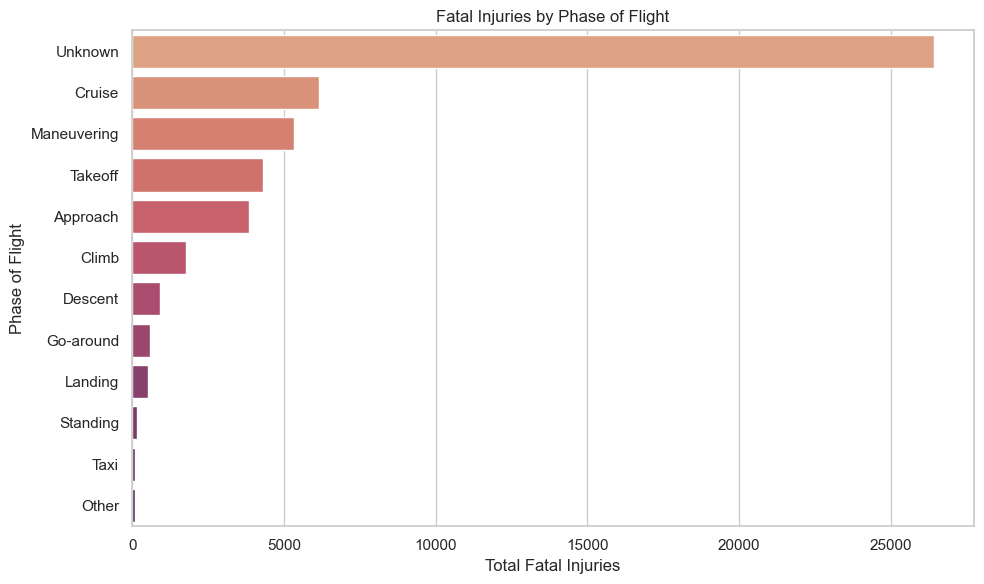

In [14]:
# Calculate total fatal injuries per phase
phase_fatalities = df_trimmed.groupby('Broad.phase.of.flight')['Total.Fatal.Injuries'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=phase_fatalities.values,
    y=phase_fatalities.index,
    palette='flare',
    ci=None  # remove error bars
)
plt.title('Fatal Injuries by Phase of Flight')
plt.xlabel('Total Fatal Injuries')
plt.ylabel('Phase of Flight')
plt.tight_layout()
plt.show()



### Interpretation: Fatal Injuries by Phase of Flight

#### Observations:
- **Unknown phase** accounts for **over 25,000** fatalities. This limits precise conclusions but signals **data incompleteness**. It may reflect weak reporting standards, especially in general aviation.
- **Cruise** and **Maneuvering** phases follow, both being mid-flight stages where **altitude, control, and weather** play a major role.
- **Takeoff** and **Approach** show lower but still significant fatal injury counts, emphasizing that dynamic transitions still pose risks.
- **Landing** and **Taxi** have the **fewest fatalities**, suggesting either better mitigation or lower severity when incidents occur during these stages.

#### Hypothesis:
- Fatalities during **Cruise and Maneuvering** might stem from **loss of control**, **unexpected weather**, or **mechanical failure**.
- The high "Unknown" count may indicate **poor documentation** or **unregulated flights** which is a key flag for investors assessing operational transparency or insurance risk.


## Interim Insight for Investors: Where the Risks Begin

Our early analysis of over 90,000 aviation incidents has surfaced **three operational indicators** that appear closely tied to elevated accident or fatality patterns:

1. **Aircraft Make:** A few manufacturers (notably **Cessna** and **Piper**) dominate the incident dataset. This could reflect:
   - High operational volume (especially in general aviation)
   - Older, legacy fleet profiles
   - Potential training or maintenance variability

2. **Engine Type:** **Reciprocating engines** (common in light aircraft) are involved in the majority of recorded incidents, possibly due to:
   - Simpler but older technology
   - Lower regulatory or maintenance thresholds
   - Widespread use in unregulated or private flight

3. **Flight Phase:** Most fatal injuries occur during **Cruise** and **Maneuvering**, not just during takeoff or landing as often assumed. However, over **25,000 fatalities** fall under “Unknown” which is a red flag for:
   - Poor record-keeping in some aviation sectors
   - Exposure to hidden risks in data-poor geographies or operations



### Why This Matters

Aviation incidents aren’t random — they cluster around specific aircraft makes, engine types, and flight phases.

Understanding these patterns helps investors:

Avoid overexposure to high-incident manufacturers

Prioritize engine types with stronger safety profiles

Steer clear of operational phases with poor risk visibility

This clarity supports risk-adjusted entry decisions, especially in leasing, logistics, or regional operations.

### Next Phase: Exploring Interaction Effects

Now that we've seen which aircraft makes, engine types, and flight phases dominate incident counts, it’s time to understand how these features interact.

Specifically, we want to uncover:

Do certain aircraft makes have higher incident frequencies in specific flight phases?

Are specific engine types more vulnerable during particular flight stages?

Where do make, engine type, and flight phase intersect to form high-risk combinations?

This will guide our understanding of systemic risks not just in isolation, but in operational context.

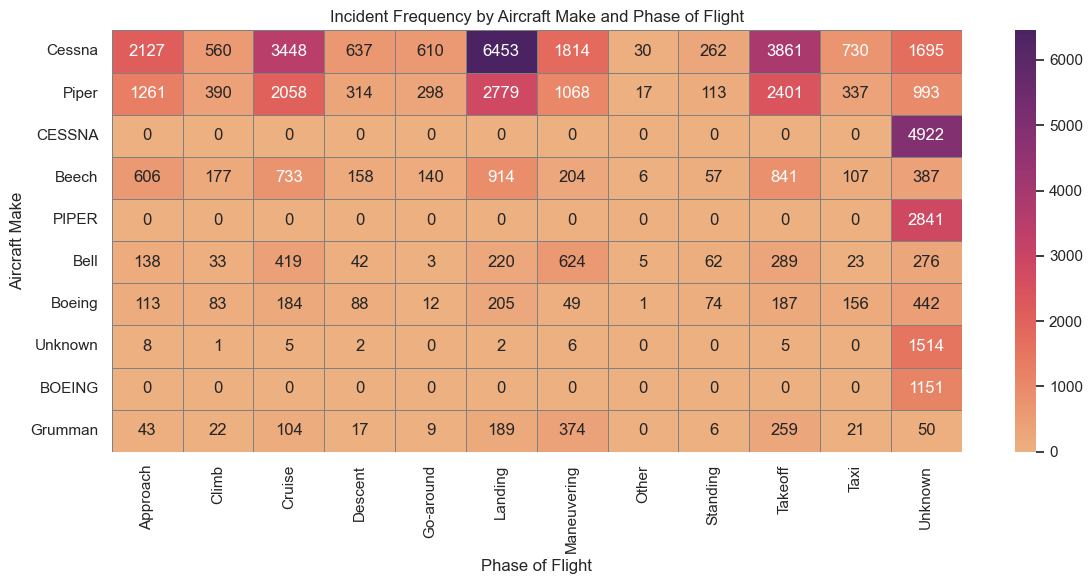

In [15]:
# Step 1: Create the cross-tab
heatmap_data = pd.crosstab(df_trimmed['Make'], df_trimmed['Broad.phase.of.flight'])

# Optional: Limit to top 10 makes to reduce clutter
top_makes = df_trimmed['Make'].value_counts().nlargest(10).index
heatmap_data = heatmap_data.loc[top_makes]

# Step 2: Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='flare', linewidths=0.5, linecolor='gray')
plt.title('Incident Frequency by Aircraft Make and Phase of Flight')
plt.xlabel('Phase of Flight')
plt.ylabel('Aircraft Make')
plt.tight_layout()
plt.show()


**Aircraft Make vs Phase of Flight**

We mapped the frequency of incidents across aircraft manufacturers and flight phases to identify where operational risk clusters.

What Stands Out:
Cessna aircraft dominate incident counts, with over 6,400 incidents during landing and another 4,900+ in unknown phases, spread across multiple Cessna variants.

Landing and take-off are consistently high-risk phases across most manufacturers aligning with aviation norms but now quantified at scale.

The "Unknown" phase holds a disproportionately large share of incidents across various makes, signaling either reporting gaps or phase-agnostic failures.


**For investors evaluating leasing portfolios or launching regional operations:**

Cessna-heavy exposure may warrant closer scrutiny especially for legacy or high-utilization fleets.

Emphasis on landing protocols and maintenance practices is vital, given its dominance in incident patterns.

Data opacity (unknown phase) could mask systemic risk which can be a critical flag when assessing insurer confidence or regulator due diligence thresholds.

**Engine Type vs Phase of Flight**

Understanding how engine configurations relate to incident patterns is critical for assessing operational risk. This heatmap focuses on identifying which engine types are more likely to be involved in incidents during specific phases of flight and is a key consideration when evaluating lease portfolios or route approvals in early-stage aviation investments.

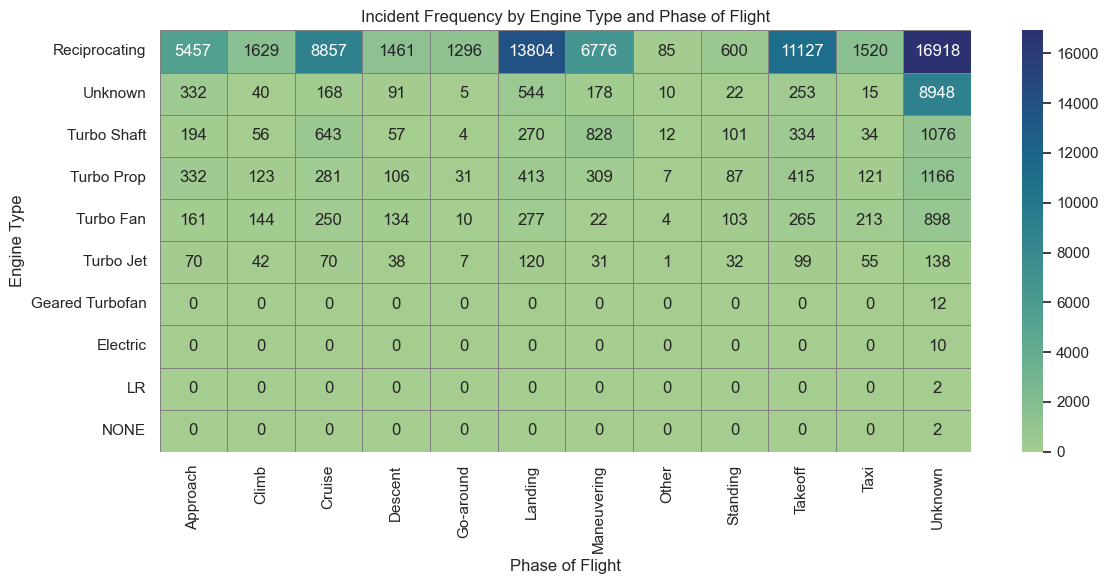

In [16]:
# Step 1: Create the cross-tab
heatmap_data = pd.crosstab(df_trimmed['Engine.Type'], df_trimmed['Broad.phase.of.flight'])

# Optional: Sort by total incident volume
top_engines = df_trimmed['Engine.Type'].value_counts().nlargest(10).index
heatmap_data = heatmap_data.loc[top_engines]

# Step 2: Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='crest', linewidths=0.5, linecolor='gray')
plt.title('Incident Frequency by Engine Type and Phase of Flight')
plt.xlabel('Phase of Flight')
plt.ylabel('Engine Type')
plt.tight_layout()
plt.show()


Reciprocating engines dominate incident counts across nearly all flight phases especially landing, take-off, and unknown stages. This concentration suggests a higher operational risk profile for reciprocating-engine aircraft.

In contrast, other engine types (e.g., turboprops, turbojets) show significantly lower and more phase-specific incident footprints, implying comparatively better safety performance or usage conditions.

When evaluating investment or operational decisions involving reciprocating engines particularly for use in critical flight phases enhanced scrutiny is warranted. Their incident prevalence may reflect design limits, usage contexts (e.g., older fleets), or maintenance sensitivities.

**Most Fatal Incident Profiles: Where Catastrophe Clusters**

In aviation, not all risks are equal, some operational profiles account for a disproportionate share of fatal outcomes.

This table highlights the top 10 incident profiles with the highest total fatal injuries, based on combinations of aircraft make, phase of flight, and purpose of flight. These profiles represent statistically concentrated zones of human loss.

Understanding these clusters supports:

Smarter capital allocation — avoiding historically high-fatality operational models

Sharper safety investments — targeting controls where the consequences are most severe

More precise underwriting — aligning risk premiums with real-world loss data

These aren’t just datapoints, they are decision signals.

In [17]:
# Install the tabulate library if not already installed
!pip install tabulate

from tabulate import tabulate

# Step 1: Prepare relevant fields and drop rows with missing fatality counts
fatal_df = df_trimmed[['Make', 'Broad.phase.of.flight', 'Purpose.of.flight', 'Total.Fatal.Injuries']].dropna()

# Step 2: Standardize categorical fields for consistency
fatal_df['Make'] = fatal_df['Make'].str.title()
fatal_df['Broad.phase.of.flight'] = fatal_df['Broad.phase.of.flight'].str.title()
fatal_df['Purpose.of.flight'] = fatal_df['Purpose.of.flight'].str.title()

# Step 3: Group by incident profile and sum fatal injuries
profile_fatalities = (
    fatal_df
    .groupby(['Make', 'Broad.phase.of.flight', 'Purpose.of.flight'], as_index=False)
    .agg({'Total.Fatal.Injuries': 'sum'})
)

# Step 4: Sort descending by fatal injuries and get top 10
top10_fatal = profile_fatalities.sort_values(by='Total.Fatal.Injuries', ascending=False).head(10)

# Step 5: Display as a clean, formatted table without row index
print("🔺 Top 10 Most Fatal Incident Profiles 🔺\n")
print(tabulate(top10_fatal, headers='keys', tablefmt='grid', showindex=False))  # showindex=False removes index column


🔺 Top 10 Most Fatal Incident Profiles 🔺

+-------------------+-------------------------+---------------------+------------------------+
| Make              | Broad.phase.of.flight   | Purpose.of.flight   |   Total.Fatal.Injuries |
+===================+=========================+=====================+========================+
| Boeing            | Unknown                 | Unknown             |                   7404 |
+-------------------+-------------------------+---------------------+------------------------+
| Cessna            | Unknown                 | Personal            |                   1389 |
+-------------------+-------------------------+---------------------+------------------------+
| Cessna            | Unknown                 | Unknown             |                   1381 |
+-------------------+-------------------------+---------------------+------------------------+
| Airbus            | Unknown                 | Unknown             |                   1317 |
+--------

## Findings & Risk Signals: Top 10 Most Fatal Incident Profiles

The incident profiles with the **highest total fatal injuries** surface three critical patterns that have direct implications for risk and capital decisions:


### 1. Boeing Leads but in the Shadows  
- Over **7,400 fatalities** are tied to **Boeing aircraft**, yet most records lack data on **flight phase** or **purpose**.
- This could suggest underreporting in major disasters or gaps in post-incident documentation.
- The opacity here is a **risk in itself** making it harder to model or manage exposure.


### 2. Cessna Recurs in High-Risk Scenarios  
- **Cessna** appears **multiple times** among the most fatal profiles.
- Key patterns:
  - Incidents during the **Cruise phase** in **personal flights**
  - Fatalities during **Maneuvering** or **Unknown** phases, again in **personal use**
- These findings highlight risks in **light/private aviation**, where oversight, pilot training, and maintenance can vary widely.


### 3. Missing Data Is Its Own Red Flag  
- Many top-fatality entries list **Unknown** flight phases or purposes.
- Whether due to poor logging or intentional omission, this missing data hides crucial risk insights.
- In aviation, **what’s not reported may be where the biggest risks lie**.
  
> The most fatal aviation risks occur where there’s **least transparency** in private flights, during uncontrolled phases, and with aircraft types that show up again and again.  
> For investors, insurers, or regulators, this demands a bias for **visible, structured operations** and a red flag on **low-data, high-impact environments**.


## Business Recommendations

Based on the analysis of over 90,000 historical aviation incidents, we provide three actionable recommendations for investors seeking risk-aware entry points into the aviation sector:


### Recommendation 1: De-risk Entry by Avoiding Reciprocating Engine Aircraft Fleets

Reciprocating engine aircraft account for **over 60,000 incidents**, leading in both fatal and non-fatal categories. This suggests systemic vulnerability potentially due to legacy designs, informal operational standards, or maintenance challenges.

**Investor Action:**  
Avoid initial exposure to reciprocating-heavy fleets or personal-use operators. Prioritize aircraft powered by **turboprop** or **turbofan** engines, which exhibit significantly lower incident rates and severity.


### Recommendation 2: Exercise Caution with Cessna and Piper Models in Personal Flight Operations

Cessna aircraft top the charts in both incident count (**20,000+ events**) and fatal outcomes. They are especially prevalent in **personal-use operations**, a segment characterized by lower oversight and operational consistency.

**Investor Action:**  
When evaluating general aviation ventures, scrutinize fleets with **Cessna** and **Piper** models. If present, demand tighter safety protocols, phase-of-flight monitoring, and clear logs on operational purpose.


### Recommendation 3: Avoid Ventures Lacking Flight Phase and Purpose-of-Use Transparency

A significant portion of incidents — including the **highest number of fatalities and injuries** occur during flights labeled with “**unknown phase**” or “**unknown purpose**.” These labels reflect poor data capture or weak compliance culture.

**Investor Action:**  
Exclude operators who cannot provide verifiable telemetry or purpose-of-use data. In early-stage investment, **visibility and traceability** of flight operations should be a minimum requirement.


These recommendations aim to reduce downside exposure by directing capital toward aircraft and operations with proven risk profiles and clearer operational oversight.


In [20]:
print(df_trimmed.columns.tolist())


['Event.Date', 'Location', 'Country', 'Make', 'Model', 'Number.of.Engines', 'Engine.Type', 'Aircraft.damage', 'Injury.Severity', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured', 'Purpose.of.flight', 'Broad.phase.of.flight', 'Weather.Condition', 'Investigation.Type', 'Report.Status', 'Airport.Name']


In [23]:
# Group 1: Incidents by Aircraft Make and Phase of Flight
df_trimmed.groupby(['Make', 'Broad.phase.of.flight']).size().reset_index(name='Incident Count') \
    .to_csv('../data/exports/tableau_aircraft_make_vs_phase.csv', index=False)

# Group 2: Incidents by Engine Type and Phase of Flight
df_trimmed.groupby(['Engine.Type', 'Broad.phase.of.flight']).size().reset_index(name='Incident Count') \
    .to_csv('../data/exports/tableau_engine_type_vs_phase.csv', index=False)

# Group 3: Incidents by Purpose of Flight and Phase of Flight
df_trimmed.groupby(['Purpose.of.flight', 'Broad.phase.of.flight']).size().reset_index(name='Incident Count') \
    .to_csv('../data/exports/tableau_purpose_vs_phase.csv', index=False)

